In [81]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos
from climpyrical.mask import gen_raster_mask_from_vector
import climpyrical.spytialProcess as sp
from climpyrical.rkrig import krigit_north

from pkg_resources import resource_filename


from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
OLD_PATH = resource_filename(
    'climpyrical',
    'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

# dsold = xr.open_dataset('/home/nannau/nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc')
dsold = xr.open_dataset(OLD_PATH)
dsold_max = dsold.rlat.values.max()

DS_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/pre_processed.nc'
)

MASK_PATH = resource_filename(
    'climpyrical',
    'nrc_data/processed/canada_mask_rp.nc'
)

ds = xr.open_dataset(DS_PATH)
mask = xr.open_dataset(MASK_PATH)['mask'].values

In [83]:
# station_dv = 'RL50 (kPa)'
# dv = 'Rain-RL50'

# station_dv = 'HDD (degC-day)'
# dv = 'heating_degree_days_per_time_period'

station_dv = 'SL50 (kPa)'
dv = 'snw'

df = pd.read_csv('./data/processed/processed_station.csv')
df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

# df = df[df[station_dv] != 0.0]

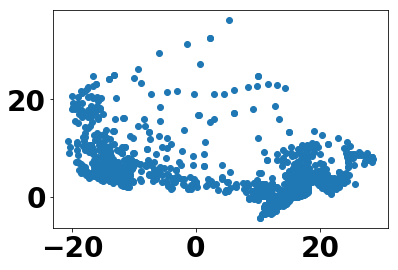

In [84]:
import matplotlib.pyplot as plt
plt.scatter(df.rlon, df.rlat)
plt.show()

In [100]:
df_north = df[df.rlat > dsold_max].copy()
df_no_zero = df[df[station_dv] != 0.0]
df_south = df_no_zero[df_no_zero.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

df

,Unnamed: 0,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,558,1009,0.976982,-4.286849,10.373390,42.27560,-82.9556,WINDSOR A,1.078971,0.602379,0.665262
1,1,559,1009,1.228341,-4.227125,10.379271,42.33330,-82.9333,WINDSOR RIVERSIDE,1.348878,0.605814,0.665262
2,2,573,1019,1.520361,-3.597423,10.826373,42.87000,-82.1800,ONR-3603,1.429491,0.707551,0.665262
3,3,573,1025,2.065695,-3.587641,11.086397,42.83000,-81.8300,ONR-3602,1.954558,0.703089,0.665262
4,4,576,1017,1.494511,-3.494586,10.713492,42.99220,-82.3047,SARNIA AIRPORT,1.345183,0.739112,0.665262
...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,1322,640,1.232479,29.595134,-5.969464,76.23165,-119.3315,MOULD BAY A,0.623250,1.315559,0.665262
1311,1311,1362,741,1.592493,31.345756,-1.484925,78.78330,-103.5330,ISACHSEN,0.637347,1.662243,0.665262
1312,1312,1391,826,0.893233,32.645419,2.272431,79.98330,-85.9333,EUREKA A,0.305200,1.947032,0.665262
1313,1313,1392,826,1.325107,32.661978,2.269768,80.00000,-85.9300,SCD-NT017,0.452763,1.947032,0.665262


# Krig the station only values in the north

In [101]:
# X_n_d =  np.stack([np.deg2rad(df.lat), np.deg2rad(df.lon)]).T
# X_n_d_r = np.stack([df.rlon, df.rlat]).T

# print(X_n_d, "\n", np.fliplr(X_n_d))
# nbrs = NearestNeighbors(n_neighbors=20, metric='haversine').fit(X_n_d)
# dist, ind = nbrs.kneighbors(X_n_d)
# imax = df.rlat.idxmax(axis=0, skipna=True)
# temp_df = df.iloc[ind[imax]]

# xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
# ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

# latlon = np.stack([temp_df.rlon, temp_df.rlat])
# stats = temp_df[station_dv]

# lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
# l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)
# ylim = u-lw
# xlim = r-l    

# z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=True)

# final = ds[dv].values.copy()
# final[:, :] = np.nan
# final[lw:u, l:r] = z.T

# nanmask = ~np.isnan(final)

# station_final_north = final.copy()

station_final_north = krigit_north(df, station_dv, 20, ds)

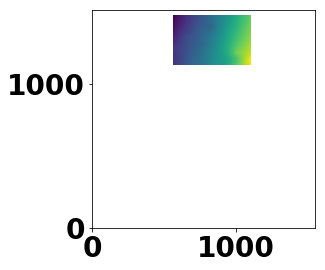

In [102]:
plt.imshow(station_final_north, origin = 'lower')

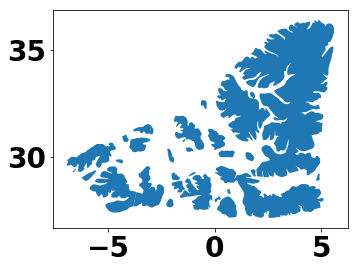

In [88]:
canada = gpd.read_file('./data/processed/canada_final.shp').geometry
def to_polygons(geometries):
    for geometry in geometries:
        if isinstance(geometry, Polygon):
            yield geometry
        else:
            yield from geometry

canada_polygons = MultiPolygon(to_polygons(canada))

polygon_above_north_idx = np.array(
    [p.centroid.y + 1 >= dsold_max for p in canada]
)

M2 = gpd.GeoSeries(
    MultiPolygon(
        [P for P in canada_polygons if (P.is_valid and P.centroid.y + 1 >= dsold_max)]
    )
)
M2.plot()

100%|██████████| 59147/59147 [00:09<00:00, 6074.31it/s]


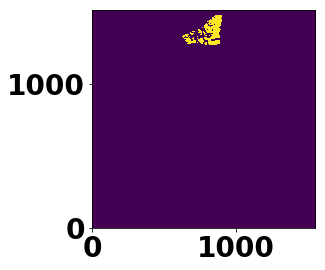

In [89]:
northern_mask = np.zeros(ds[dv].shape) == 1.0
north_ext = 210
northern_mask[-(north_ext+50):, :] = gen_raster_mask_from_vector(
    ds.rlon.values, 
    ds.rlat.values[-(north_ext+50):], 
    M2
)

station_final_north[~northern_mask] = np.nan
plt.imshow(northern_mask, origin='lower')

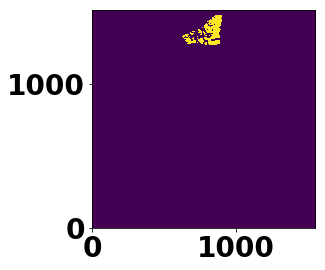

In [90]:
plt.imshow(~np.isnan(station_final_north), origin='lower')

## Find areas in north that are not covered by station only reconstruction

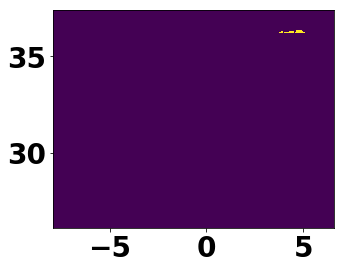

In [91]:
north_nan = ~np.isnan(station_final_north)
missed_station_only = (northern_mask^north_nan)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]

plt.imshow(missed_station_only, origin='lower', extent=extent)
plt.gca().set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
plt.gca().set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.show()

# station_final_north[~northern_mask] = np.nan

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
f = NearestNDInterpolator(np.stack([rlon[north_nan], rlat[north_nan]]).T, station_final_north[north_nan])

station_final_north_filled = station_final_north.copy()
station_final_north_filled[missed_station_only] = f(np.stack([rlon[missed_station_only], rlat[missed_station_only]]).T)

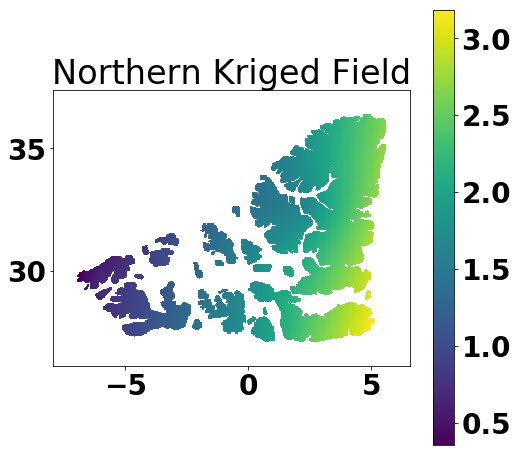

In [92]:
matplotlib.rc('font', **font)

extent = [ds.rlon.values.min(), ds.rlon.values.max(), ds.rlat.values.min(), ds.rlat.values.max()]
fig, ax = plt.subplots(figsize=(8, 8))
img = ax.imshow(station_final_north_filled, origin='lower', extent = extent)
ax.set_ylim(M2.bounds.miny.min()-1, M2.bounds.maxy.max()+1)
ax.set_xlim(M2.bounds.minx.min()-1, M2.bounds.maxx.max()+1)
plt.colorbar(img)
plt.title("Northern Kriged Field")
plt.savefig("northern_krig")

In [93]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

df['ilocy'] = iy 
df['ilocx'] = ix
df
np.any(df.ratio < 0)

False

In [94]:
# choose starting value
model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
station_vals = df[station_dv]
best_tol = df.best_tol.mean()    

print(best_tol)

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

mean_corrected

0.6652619443881096


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [73]:
df

,Unnamed: 0,ilocy,ilocx,SL50 (kPa),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,0,558,1009,0.976982,-4.286849,10.373390,42.27560,-82.9556,WINDSOR A,1.078971,0.602379,0.665262
1,1,559,1009,1.228341,-4.227125,10.379271,42.33330,-82.9333,WINDSOR RIVERSIDE,1.348878,0.605814,0.665262
2,2,573,1019,1.520361,-3.597423,10.826373,42.87000,-82.1800,ONR-3603,1.429491,0.707551,0.665262
3,3,573,1025,2.065695,-3.587641,11.086397,42.83000,-81.8300,ONR-3602,1.954558,0.703089,0.665262
4,4,576,1017,1.494511,-3.494586,10.713492,42.99220,-82.3047,SARNIA AIRPORT,1.345183,0.739112,0.665262
...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1310,1322,640,1.232479,29.595134,-5.969464,76.23165,-119.3315,MOULD BAY A,0.623250,1.315559,0.665262
1311,1311,1362,741,1.592493,31.345756,-1.484925,78.78330,-103.5330,ISACHSEN,0.637347,1.662243,0.665262
1312,1312,1391,826,0.893233,32.645419,2.272431,79.98330,-85.9333,EUREKA A,0.305200,1.947032,0.665262
1313,1313,1392,826,1.325107,32.661978,2.269768,80.00000,-85.9300,SCD-NT017,0.452763,1.947032,0.665262


/home/nannau/09092020/climpyrical/climpyrical/gridding.py:351: UserWarning: -4.2868489102278735 is outside of array's domain between -4.096673303070716 and 19.69502878238771.             A station is outside of the CanRCM4 model grid space.
  A station is outside of the CanRCM4 model grid space."


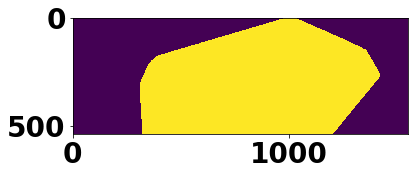

In [75]:
latlon = np.stack([df.rlon, df.rlat])
hull = ConvexHull(points=latlon.T)
poly = Polygon(latlon.T[hull.vertices])
poly_mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values[l:r], gpd.GeoSeries(poly), progress_bar=False)
plt.imshow(poly_mask)

In [76]:
ok = OrdinaryKriging(
    df.rlon, 
    df.rlat, 
    df.ratio, 
    exact_values=False,
    variogram_function='exponential',
)
z, ss = ok.execute("grid", ds.rlon.values, ds.rlat.values, backend='C', n_closest_points=40)

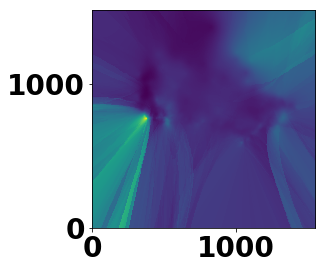

In [77]:
plt.imshow(z, origin='lower')

In [75]:
df[['rlon', 'rlat', 'ratio']].values[:, :2]
import rpy2

rpy2.rinterface_lib.embedded.RRuntimeError

In [110]:
from climpyrical.rkrig import rkrig_r
Zl = rkrig_r(df, south_index[:100], 30, ds)

 60%|██████    | 60/100 [00:49<00:54,  1.37s/it]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 2.276 0 2.277

 62%|██████▏   | 62/100 [00:52<00:49,  1.31s/it]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.183 0 0.183

100%|██████████| 100/100 [01:31<00:00,  1.14s/it]


In [111]:
# Zl = []

# X_distances = np.stack([np.deg2rad(df.lat.values), np.deg2rad(df.lon.values)])
# dx = ((np.amax(ds.rlon.values)-np.amin(ds.rlon.values))/ds.rlon.size)
# dy = ((np.amax(ds.rlat.values)-np.amin(ds.rlat.values))/ds.rlat.size)
# dA = dx*dy

# xyr = df[['rlon', 'rlat', 'ratio']].values

# def krig_at_field(ds, temp_xyr):
        
#     xmin, xmax = temp_xyr[:, 0].min(), temp_xyr[:, 0].max()
#     ymin, ymax = temp_xyr[:, 1].min(), temp_xyr[:, 1].max()

#     latlon = temp_xyr[:, :2].T
#     stats = temp_xyr[:, 2]

#     lw, u = find_nearest_index(ds.rlat.values, ymin), find_nearest_index(ds.rlat.values, ymax)
#     l, r = find_nearest_index(ds.rlon.values, xmin), find_nearest_index(ds.rlon.values, xmax)

#     ylim = u-lw
#     xlim = r-l

#     z, x, y = sp.fit(latlon, stats, xlim, ylim, extrap=False)

#     final = np.ones(ds[dv].values.shape, dtype=np.float16)
#     final[:] = np.nan
#     final[lw:u, l:r] = z.T
    
#     return final

# with tqdm(total=len(south_index), position=0, leave=True) as pbar:
#     for i in south_index:
#         pbar.update()
#         nn = 30

#         nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
#         dist, ind = nbrs.kneighbors(X_distances.T)
#         temp_xyr = xyr[ind[i], :]

#         latlon = temp_xyr[:, :2]
#         stats = temp_xyr[:, 2]
#         hull = ConvexHull(points=latlon)
# #         poly = Polygon(latlon.T[hull.vertices])

#         while hull.area < dA*(3*10)**2:
#             nn+=1
#             nbrs = NearestNeighbors(n_neighbors=nn, metric='haversine').fit(X_distances.T)
#             dist, ind = nbrs.kneighbors(X_distances.T)

#             temp_xyr = xyr[ind[i], :]
#             latlon = np.stack([temp_df.rlon, temp_df.rlat])

#             hull = ConvexHull(points=latlon.T)

#         try:
#             final = krig_at_field(ds, temp_xyr)
#             final_da = da.from_array(final, chunks=(250, 250))
#             Zl.append(final_da)

#         except rpy2.rinterface_lib.embedded.RRuntimeError:
#             continue
            


In [112]:
from climpyrical.rkrig import rkrig_r
# rkrig_r(df, south_index, 30, ds)

In [113]:
cxmin, cxmax, cymin, cymax = canada.bounds.minx.min(), canada.bounds.maxx.max(), canada.bounds.miny.min(), canada.bounds.maxy.max()

In [114]:
final = np.zeros(ds[dv].shape)
final_arr = da.stack(Zl, axis=0)
# final_arr = np.stack(np.array(Zl), axis=0)
final = da.nanmean(final_arr, axis = 0)
ratio = final.compute()
# ratio = z.copy()
ratio[~mask] = np.nan

/home/nannau/tri/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


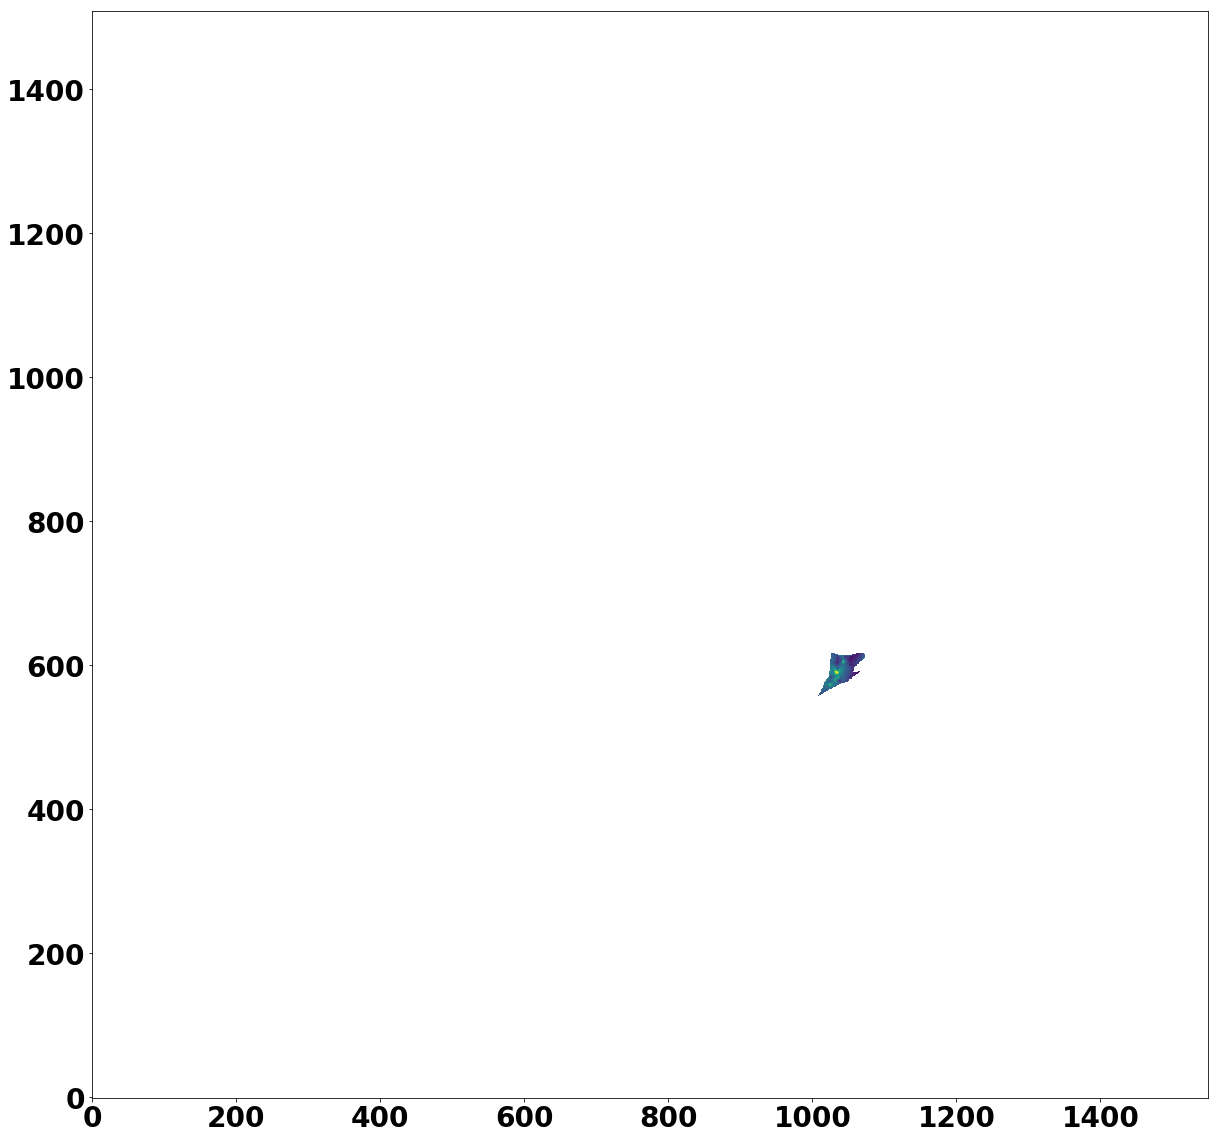

In [115]:
plt.figure(figsize=(20, 20))
plt.imshow(np.array(ratio, dtype=np.float), origin='lower')

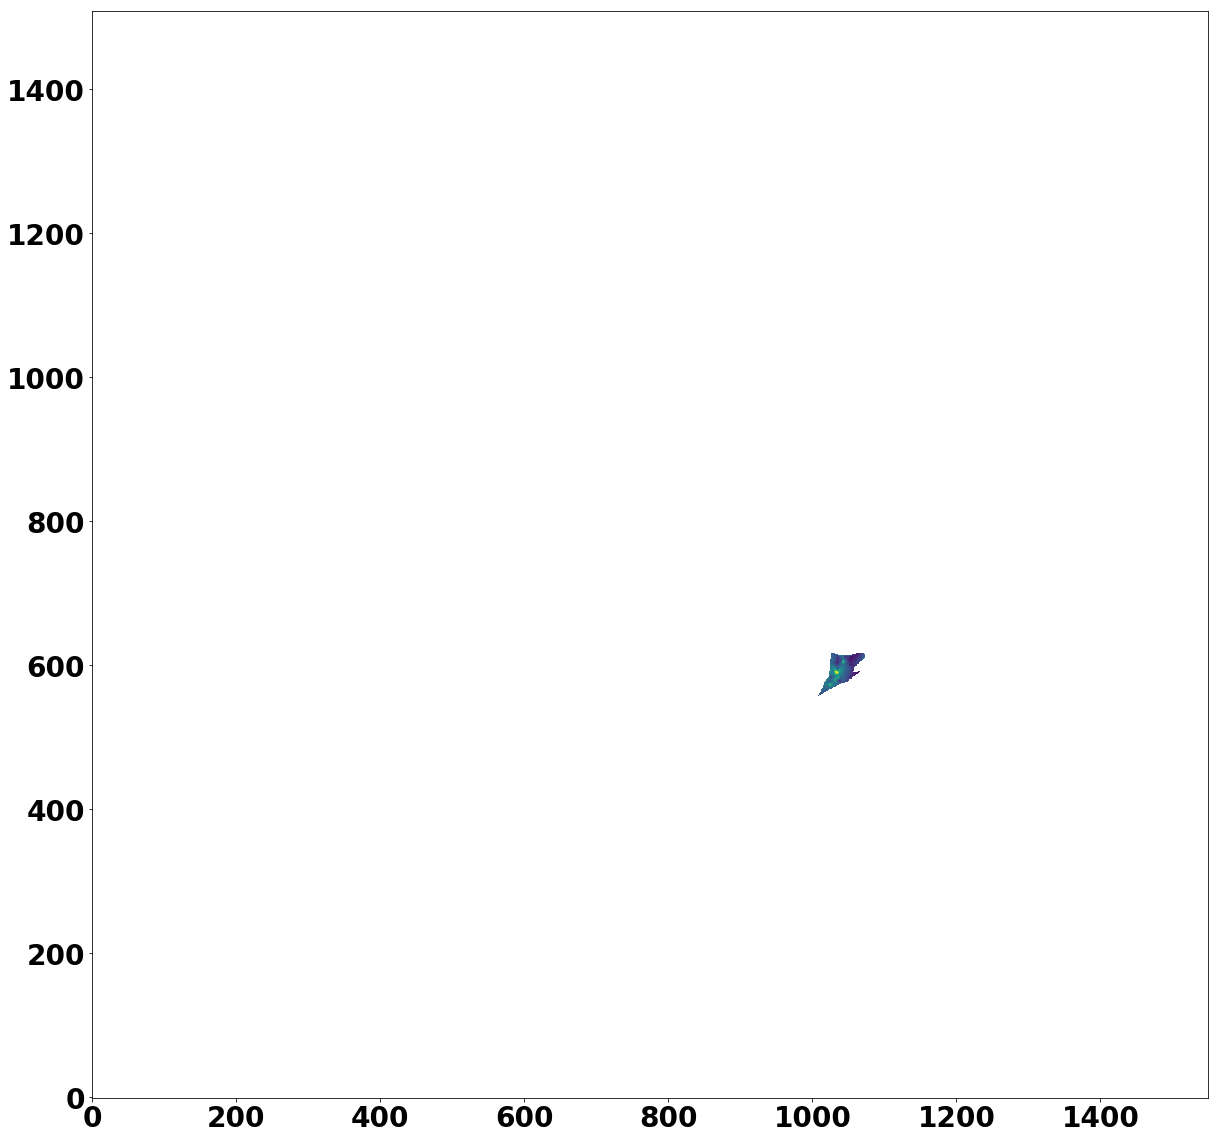

In [116]:
ratio = np.array(ratio, dtype=np.float)
plt.figure(figsize=(20, 20))
plt.imshow(ratio, origin='lower')


/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


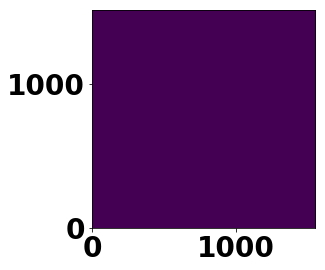

In [117]:
nanmask = ~np.isnan(ratio)
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
ratio_final = ratio.copy()

f = NearestNDInterpolator(np.stack([rlon[nanmask], rlat[nanmask]]).T, ratio[nanmask])

ratio_final[nanmask^mask] = f(np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T)
ratio_final = ratio_final*mean_corrected

plt.imshow(ratio_final < 0, origin='lower')

In [118]:
from shapely.geometry import MultiPolygon
pts=[]
for poly in canada:
    if isinstance(poly, MultiPolygon):
        for p in poly:
            pts.extend(p.exterior.coords)
            pts.append([None, None])
    else:
        pts.extend(poly.exterior.coords)
        pts.append([None, None])

X, Y = zip(*pts)

In [119]:
np.sum(ratio < 0)

print(canada.geometry.bounds.miny.min(), canada.geometry.bounds.maxy.max())
canada[1].bounds

-4.786119977095354 36.38693291647601


/home/nannau/tri/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(-20.801680964041292,
 2.7139169736444946,
 -11.099795673725668,
 18.14315282432355)

[ 0  6 12 18 24]


/home/nannau/tri/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


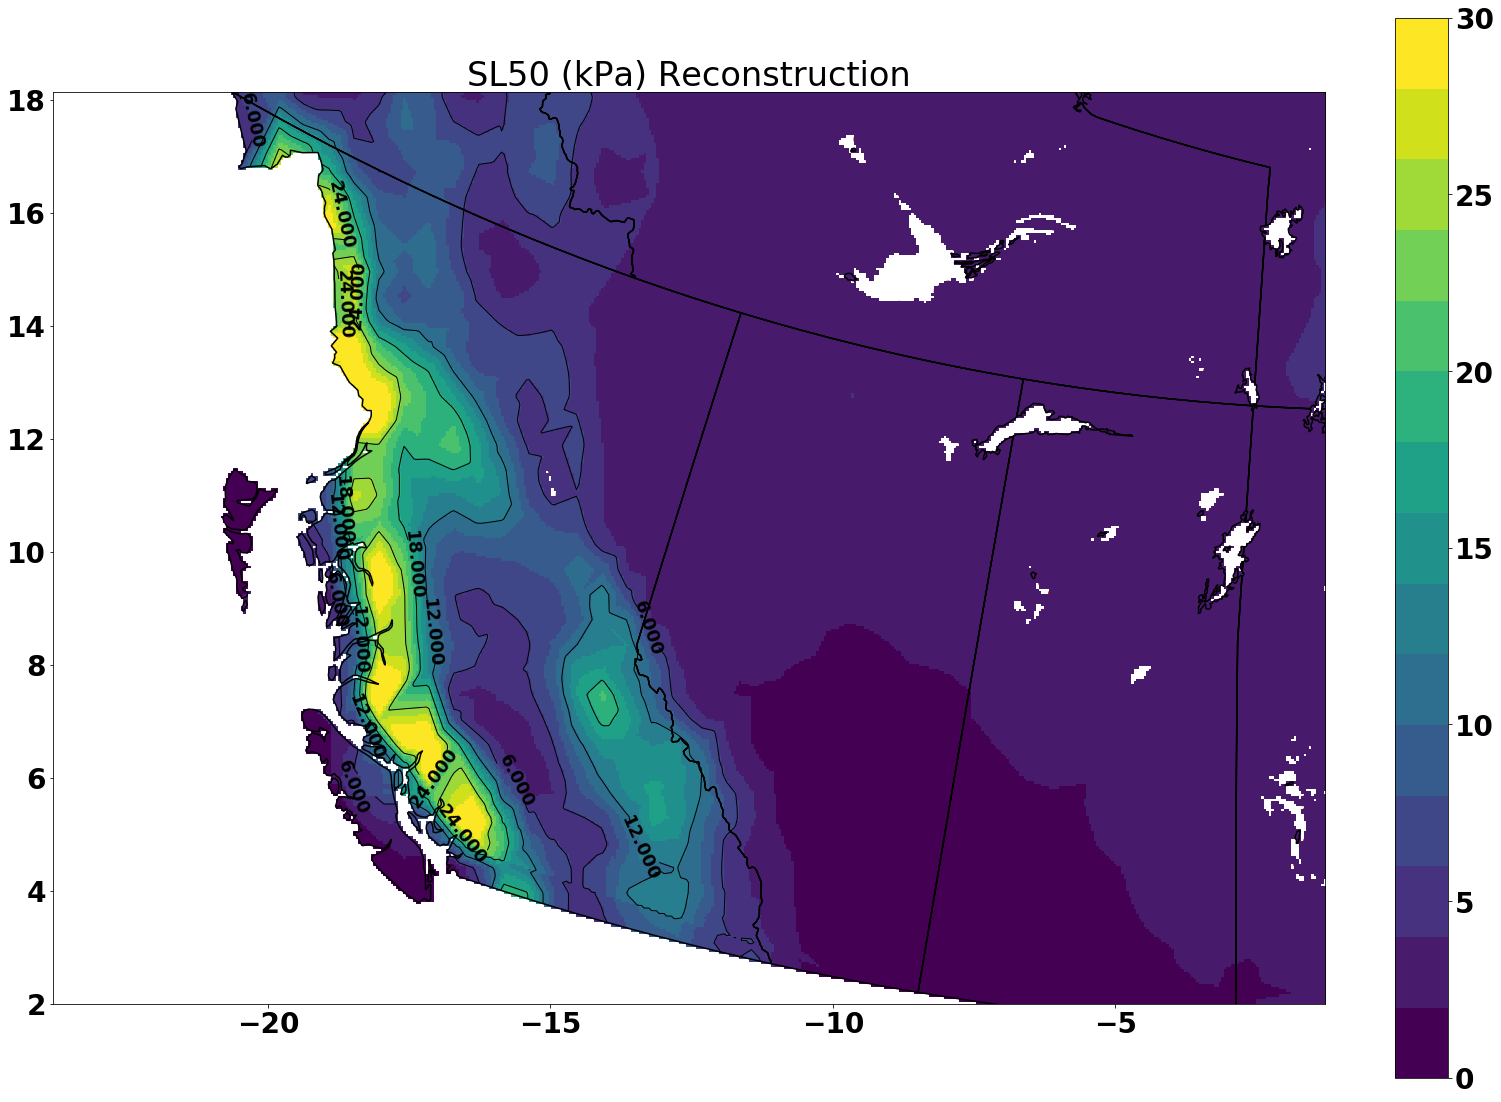

In [120]:
ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))

# vmax = np.nanmax(df[station_dv].values)
# vmin = np.nanmin(df[station_dv].values)
vmin = 0
vmax = 30


N = 15
cont = np.arange(vmin, vmax, 6)
print(cont)

# ax.text(-20, -10, 'Reconstruction Min: {}'.format(np.round(np.nanmin(ratio_final), 3)))
# ax.text(-20, -12, 'Reconstruction Max: {}'.format(np.round(np.nanmax(ratio_final), 3)))
# # ax.text(-13, -12, 'Reconstruction Max: {}'.format(np.nanmax(ratio_final)))
# ax.text(-20, -14, 'Reconstruction Mean: {}'.format(np.round(np.nanmean(ratio_final), 3)))


# ax.text(1.5, -10, 'Station Min: {}'.format(np.round(np.min(df[station_dv]), 3)))
# ax.text(1.5, -12, 'Station Max: {}'.format(np.max(df[station_dv])))
# ax.text(1.5, -14, 'Station Mean: {}'.format(np.round(np.nanmean(df[station_dv]), 3)))

# ax.text(17, -10, 'Model Min: {}'.format(np.round(np.nanmin(ds[dv]), 3)))
# ax.text(17, -12, 'Model Max: {}'.format(np.round(np.nanmax(ds[dv]), 3)))
# ax.text(17, -14, 'Model Mean: {}'.format(np.round(np.nanmean(ds[dv]), 3)))

col1 = ax.imshow(ratio_final, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, ratio_final, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

# ax.set_xlim(cxmin-1, cxmax+1)
# ax.set_ylim(cymin-1, cymax+1)
# ax.set_ylim(
ax.set_xlim(canada[1].bounds[0]-3, canada[1].bounds[1]-4)
ax.set_ylim(2, canada[1].bounds[3])

# ax.set_xlim(canada[1].geometry.bounds.minx.min()-5, canada[1].geometry.bounds.maxx.max()+5)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Reconstruction')
canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-BC-full-reconstruction-patched.png')

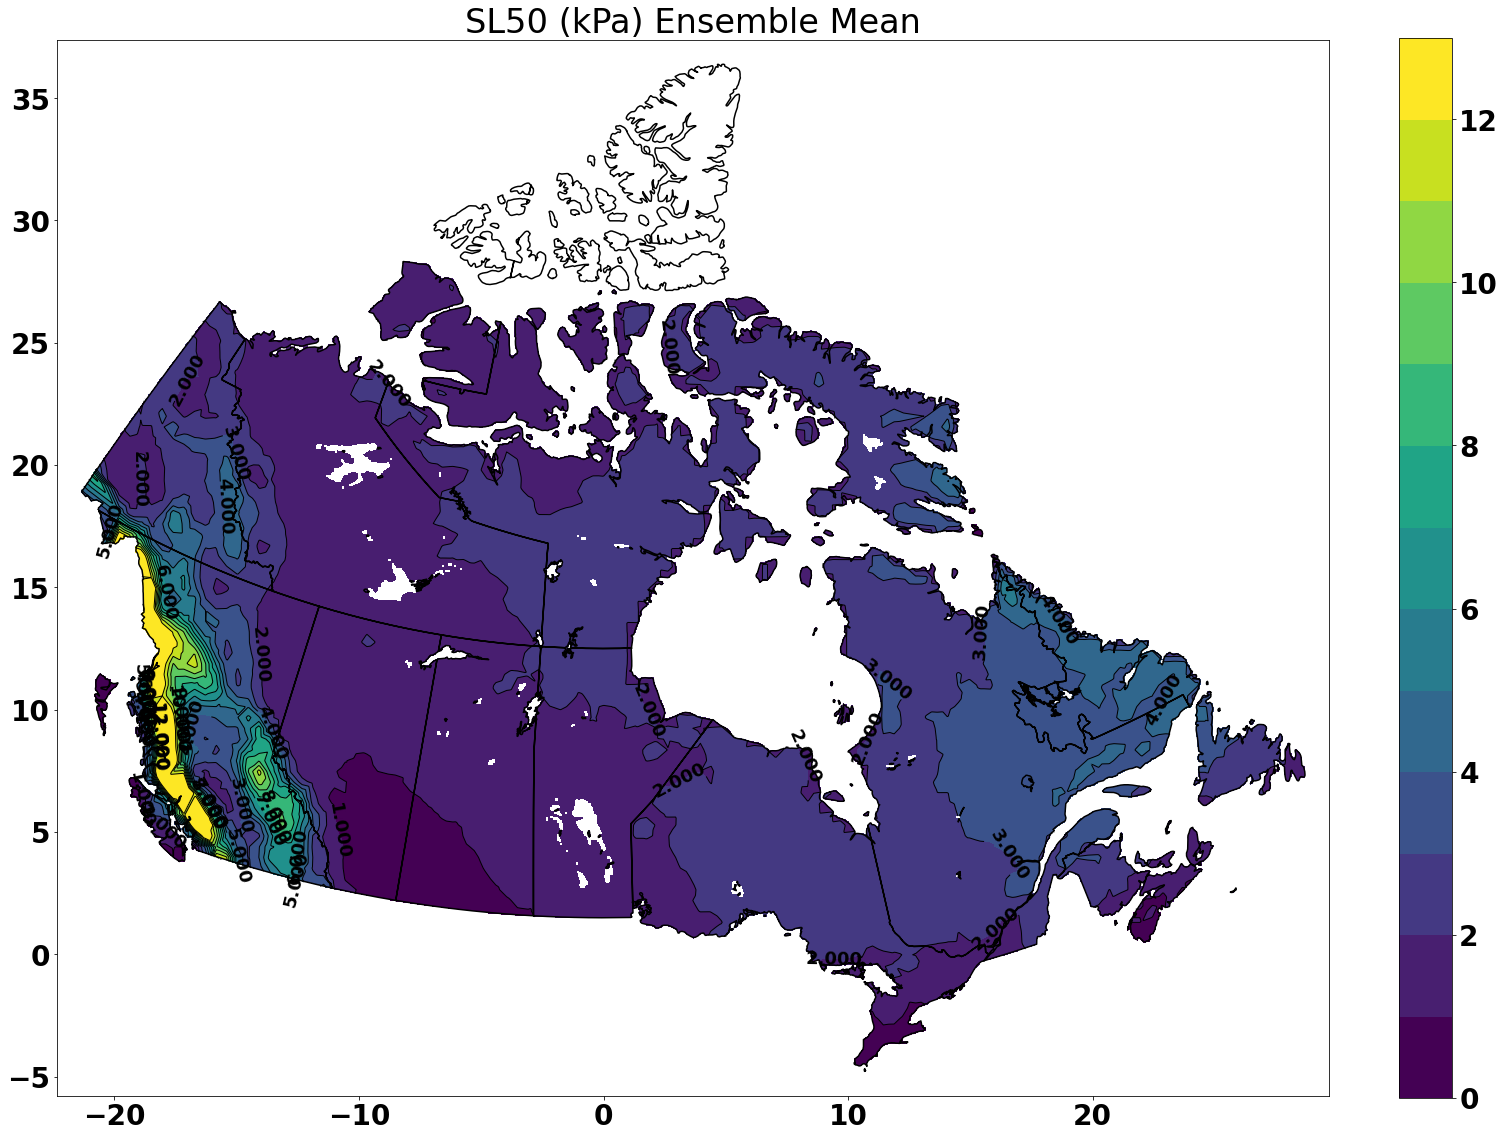

In [28]:
mean = ds[dv].values
mean[~mask] = np.nan
mean[northern_mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 25))



col1 = ax.imshow(mean, origin='lower', extent=extent, vmin=vmin, vmax=vmax, cmap = plt.cm.get_cmap("viridis", N))
CS = ax.contour(ds.rlon, ds.rlat, mean, cont, colors='black', linewidths=1, zorder=4)
plt.colorbar(col1, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.clabel(CS, fontsize=18, inline=1)
ax.set_title(station_dv+' Ensemble Mean')
# canada.plot(ax=ax, color='red', zorder=0)
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-mean.png')

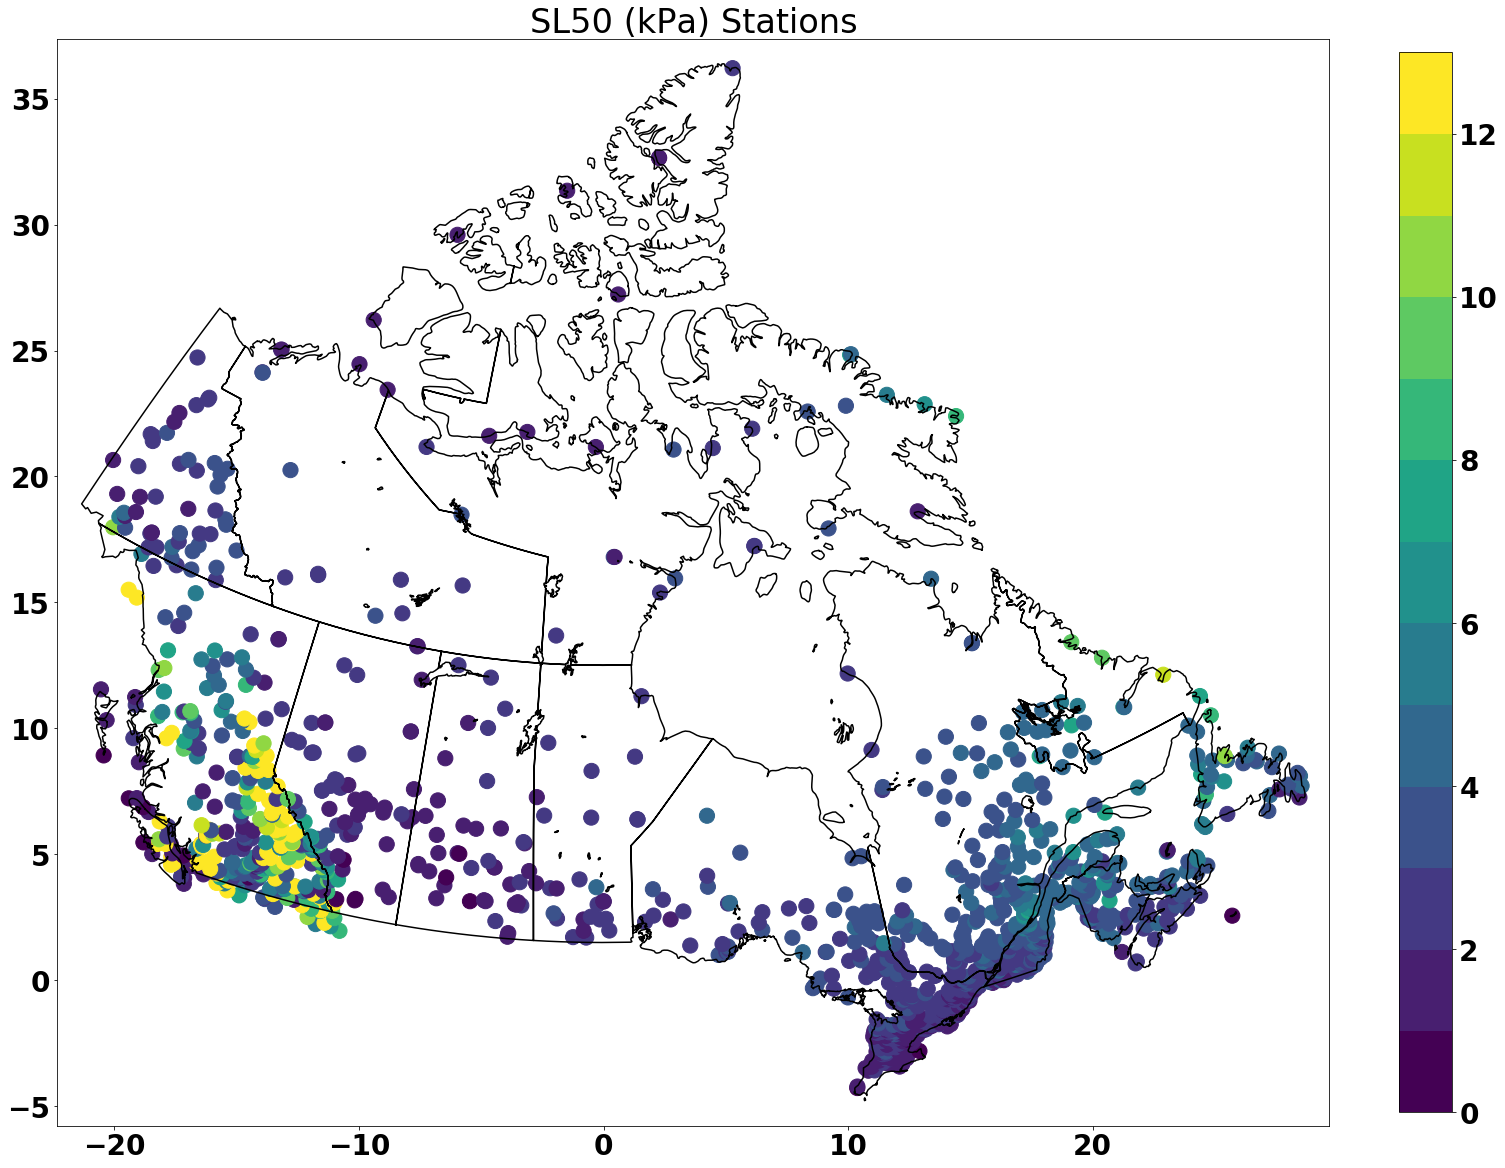

In [87]:
# ratio_final[northern_mask] = np.array(station_final_north_filled)[northern_mask]
# ratio_final[~mask] = np.nan
fig, ax = plt.subplots(figsize=(25, 20))

sc = ax.scatter(df.rlon, df.rlat, c = df[station_dv], s=230, vmin = vmin, vmax = vmax, cmap = plt.cm.get_cmap("viridis", N))
plt.colorbar(sc, ax = ax, fraction=0.038, pad=0.05)

ax.set_xlim(cxmin-1, cxmax+1)
ax.set_ylim(cymin-1, cymax+1)

ax.set_title(station_dv+' Stations')
ax.plot(X, Y, color='black')

plt.savefig(f'./data/plots/{dv}-stations.png')

# Write to Table C-2


In [88]:
matched_df_nrc = pd.read_csv('./data/processed/nrc_locations.csv')

nrc_nan_df = matched_df_nrc[np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])]

ratio_nan = ~np.isnan(ratio_final)
    
f = NearestNDInterpolator(np.stack([rlon[ratio_nan], rlat[ratio_nan]]).T, ratio_final[ratio_nan])

table_nan = f(
    np.stack(
        [rlon[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values], 
         rlat[nrc_nan_df.ilocy.values, nrc_nan_df.ilocx.values]
        ]).T).T

# matched_df_nrc[''][np.isnan(ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx])] = table_nan
# matched_df_nrc

design_value = ratio_final[matched_df_nrc.ilocy, matched_df_nrc.ilocx]
dvnan = np.isnan(design_value)
design_value[dvnan] = table_nan

nrc_table = pd.DataFrame()
nrc_table = nrc_table.assign(
    Location=matched_df_nrc.Location, 
    lat=matched_df_nrc.lat, 
    lon=matched_df_nrc.lon,
    rlat=matched_df_nrc.rlat, 
    rlon=matched_df_nrc.rlon,
    SL50=design_value)

assert not df.isnull().values.any()

nrc_table.round(3).to_csv("./data/processed/table_c2_"+dv+".csv")